# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [345]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

plt.rcParams['figure.figsize'] = (5, 4)

In [346]:
# data file: https://www.marketwatch.com/investing/stock/sbux/download-data?startDate=1/1/2021&endDate=11/27/2024
data_file = 'C:\\Users\\stefa\\Documents\\workspaces\\szx81\\SBUX\\test_data\\SBUX0_1D_1.01.2021-27.11.2024.csv'
data = pd.read_csv(data_file, index_col = 'Date', parse_dates=True)
data['Volume'] = data['Volume'].apply(lambda x: float(x.replace(',', '')))

training_data_count = 200
training_data = data[:training_data_count:].copy(deep=True)
testing_data = data[training_data_count:].copy(deep=True)

print(f'total data length: {len(data)}')
print(f'training data length: {len(training_data)}')
print(f'testing data length: {len(testing_data)}')
data.head(5)

total data length: 254
training data length: 200
testing data length: 54


,Open,High,Low,Close,Volume
Date,,,,,
2024-11-27,100.75,102.03,100.72,101.51,4857843.0
2024-11-26,101.99,102.09,100.47,100.68,6558260.0
2024-11-25,102.93,103.32,101.78,101.84,8839592.0
2024-11-22,100.00,102.56,99.77,102.50,6563290.0
2024-11-21,99.50,100.33,98.49,100.06,6760622.0


In [347]:
data['Close']


Date
2024-11-27    101.51
2024-11-26    100.68
2024-11-25    101.84
2024-11-22    102.50
2024-11-21    100.06
               ...  
2023-12-01     99.20
2023-11-30     99.30
2023-11-29     99.85
2023-11-28    101.18
2023-11-27    102.36
Name: Close, Length: 254, dtype: float64

<Axes: title={'center': 'Star Bucks Stock "Close"'}, xlabel='Date'>

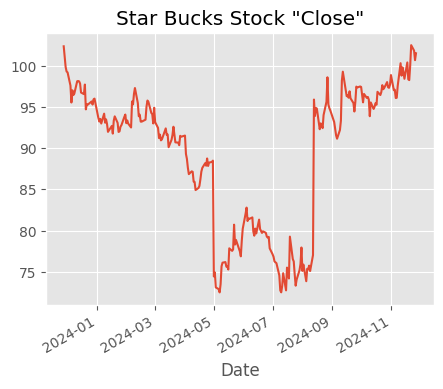

In [348]:
plt.style.use('ggplot')
data['Close'].plot(label='CLOSE', title='Star Bucks Stock "Close"')

In [349]:
feature_list = [0, 1, 2, 3, 4] # called ``feature list`` or in ``input`` one
output_list = [0, 1, 2, 3, 4]
data_columns = list(data.columns)
def output_name(index):
    return data_columns[output_list[index]]
def feature_name(index):
    return data_columns[feature_list[index]]

In [350]:
def data_preprocessing(df):
    X = StandardScaler().fit_transform(df.iloc[:, feature_list]) # all columns
    X = Variable(torch.Tensor(X))
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = MinMaxScaler().fit_transform(df.iloc[:, output_list] ) # 'Close' column
    y = Variable(torch.Tensor(y))

    return X, y

def nn_trening_result(lstm, df, offset=0, label='', color='blue', alpha=1, verbose=None):
    X, y = data_preprocessing(df)
    
    (mm := MinMaxScaler()).fit_transform(df.iloc[:, output_list]) # 'Close' column
    y = mm.transform(df.iloc[:, output_list]) #old transformers
    y = Variable(torch.Tensor(y))    #reshaping the dataset

    y_np = y.data.numpy()
    y_np = np.transpose(mm.inverse_transform(y_np))

    nn_answer = lstm(X)#forward pass

    if verbose is not None:
        print(f'''
              {verbose}
formatted feature data (length is {len(df)}): 
    {df[:1]}

NN question[:1] (converted from formatted feature data, length is {len(X)}):
    {X[:1]}
NN answer[:5] (length is {len(nn_answer)}): 
    {nn_answer[:1]}
              ''')

    data_predict = nn_answer.data.numpy() #numpy conversion
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    time = [_ for _ in range(offset, offset + len(df))]

    data_predict = np.transpose(data_predict)
    for i in range(len(data_predict)):
        diff_0 = y_np[i][0] - data_predict[i][0]
        y_np[i] = y_np[i] - diff_0
        plt.plot(time, y_np[i], label=label + f'- Actual "{output_name(i)}" Data', color='black', 
                 alpha=0.2, linewidth=5) #actual plot
        plt.plot(time, data_predict[i], label=label + f'- Predicted "{output_name(i)}" Data', 
                 color=color, alpha=alpha) #predicted plot
        # plt.title('Time-Series Prediction')
        plt.legend()
        plt.show() 

In [ ]:
class LSTM_spec(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, fully_connected, 
                 num_layers, seq_length):
        super(LSTM_spec, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_hid =  nn.Linear(hidden_size, fully_connected) #fully connected 1ayer
        self.fc_out = nn.Linear(fully_connected, num_classes) #fully connected out layer 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_hid(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_out(out) #Final Output
        return out

In [352]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = len(feature_list) #number of features
hidden_size = 2 # number of features in hidden state
fully_connected = 128 # connections between hidden layers

num_layers = 1 #number of stacked lstm layers

num_classes = len(output_list) #number of output classes 

In [353]:
X_train, y_train = data_preprocessing(training_data)
lstm = LSTM_spec(num_classes, input_size, hidden_size, fully_connected,
             num_layers, X_train.shape[1]) #our lstm class

In [359]:
print(X_train[0])
print(y_train[0])

tensor([[ 1.4526,  1.4924,  1.5494,  1.5263, -0.5189]])
tensor([0.9290, 0.9577, 0.9649, 0.9670, 0.0098])


In [354]:
criterion = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [355]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train) # forward pass
  optimizer.zero_grad() # initiate gradient
  loss = criterion(outputs, y_train) # loss function
  loss.backward() # calculate the loss
  optimizer.step() # try to decrease loss, back-prop

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.30913
Epoch: 100, loss: 0.06063
Epoch: 200, loss: 0.00306
Epoch: 300, loss: 0.00184
Epoch: 400, loss: 0.00171
Epoch: 500, loss: 0.00166
Epoch: 600, loss: 0.00163
Epoch: 700, loss: 0.00160
Epoch: 800, loss: 0.00156
Epoch: 900, loss: 0.00150


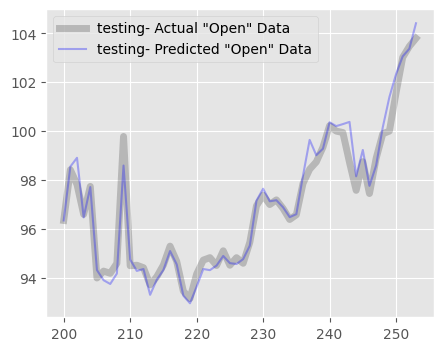

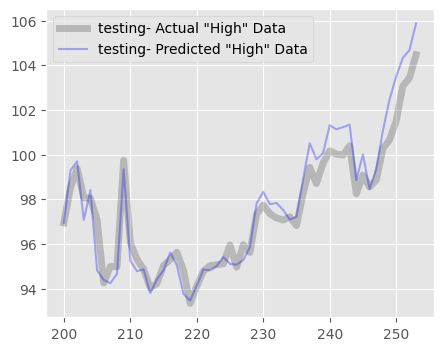

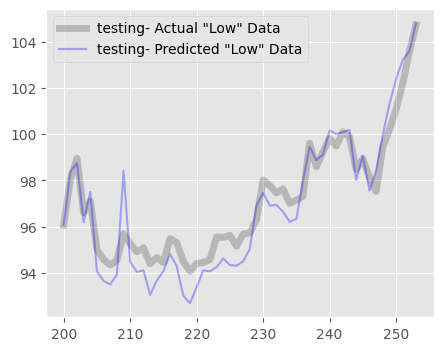

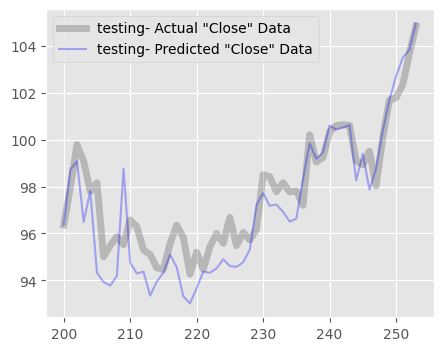

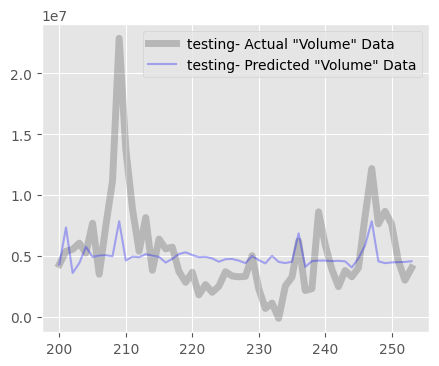

In [356]:
nn_trening_result(lstm, testing_data,
        offset=len(training_data), label='testing', color='blue', alpha=0.3)

In [357]:
print(lstm)

LSTM_spec(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_hid): Linear(in_features=2, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)


In [358]:
X, y = data_preprocessing(testing_data)
X[0]
y[0]
nn_answer = lstm(X)
nn_answer = np.transpose(nn_answer.detach().numpy())
nn_answer[0]

array([0.44173452, 0.64878774, 0.68242407, 0.45345613, 0.5700029 ,
       0.25097182, 0.21207   , 0.1975978 , 0.23769894, 0.65269434,
       0.2914885 , 0.24775489, 0.2550029 , 0.1559383 , 0.2137548 ,
       0.2515465 , 0.32415766, 0.27302098, 0.15264031, 0.12343603,
       0.18715282, 0.25512946, 0.2507341 , 0.2685973 , 0.30534667,
       0.2776336 , 0.27431917, 0.29316434, 0.3450457 , 0.5177436 ,
       0.56361127, 0.5152767 , 0.5194529 , 0.49232343, 0.45445406,
       0.465769  , 0.6135293 , 0.75125766, 0.69240797, 0.7173139 ,
       0.8189504 , 0.80426824, 0.81192863, 0.820449  , 0.611367  ,
       0.7126423 , 0.5747359 , 0.65269434, 0.7991867 , 0.9158777 ,
       1.0035923 , 1.0721788 , 1.1014311 , 1.1993704 ], dtype=float32)